## Thông tin nhóm

**Thành viên thứ 1:**

- Họ và tên: Trần Trung Hiếu
- MSSV: 1712442

**Thành viên thứ 2:**
- Họ và tên: Lê Long Hồ
- MSSV: 1712447

**Thành viên thứ 3:**
- Họ và tên: Nguyễn Đình Thiên Phúc
- MSSV: 18120144

___

## Import

In [1]:
!pip3 install -q cython nltk pyvi

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from pyvi import ViTokenizer
from nltk.stem.porter import PorterStemmer
import string

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/tthieu22_06/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


---

## Thu thập dữ liệu

Phần thu thập dữ liệu được code trong file movieCrawling.py. Cần install các thư viện bs4, selenium, time, urllib. Tải file chromedriver.exe và đặt trong cùng folder và chạy file movieCrawling.py

Đầu tiên thu thập url của các phim thuộc các danh mục sau:
- https://www.themoviedb.org/tv
- https://www.themoviedb.org/tv/on-the-air
- https://www.themoviedb.org/tv/top-rated
- https://www.themoviedb.org/movie
- https://www.themoviedb.org/movie/now-playing
- https://www.themoviedb.org/movie/top-rated

Bước này được thực hiện qua hàm getMovieUrl. Sẽ lần lượt truy cập vào các url danh mục trên, thu thập tất cả url chi tiết phim có trong đó bằng cách scroll đến khi hết trang. Mỗi danh mục sẽ có gần 2k phim. Tổng cộng thu thập gần 6k url của phim và ghi vào file movie_url.csv

---

Phần sau cùng tiến hành thu thập thông tin chi tiết của mỗi trong file movie_url.csv bằng hàm crawlMovieInfomation thông qua cách parse html. Các thông tin được lấy là:
- url: url của phim
- title: tên phim
- score: điểm 
- posterImagePath: đường dẫn chứa poster phim
- certification: nhãn phim (độ tuổi)
- overview: tóm tắt phim
- tagline
- genres: Thể loại
- trailerUrl: url trailer của phim
- language: ngôn ngữ của phần overview

Poster của phim được download bằng urllib và lưu ở posterImagePath

## Khám phá dữ liệu

In [2]:
movie_df = pd.read_csv('movie_final.csv')
movie_df.sample(5)

,url,title,score,posterImagePath,certification,overview,tagline,genres,trailerUrl,language
4864,https://www.themoviedb.org/movie/15383,Army of Shadows\n(1969),80.0,poster_final/15383.jpg,16,"Betrayed by an informant, Philippe Gerbier fin...",Betrayal. Loyalty. Collaboration. Resistance.,"Phim Chiến Tranh, Phim Chính Kịch, Phim Gây Cấn",NaN,en
4663,https://www.themoviedb.org/movie/1891,Chiến Tranh Giữa Các Vì Sao 5: Đế Chế Phản Côn...,84.0,poster_final/1891.jpg,PG,Trước sự truy đuổi gắt gao của quân đội đế quố...,The Adventure Continues...,"Phim Phiêu Lưu, Phim Hành Động, Phim Khoa Học ...",NaN,vi
1690,https://www.themoviedb.org/tv/93406,EFL on Quest\n(2018),60.0,poster_final/93406.jpg,NaN,Match highlights of all the action from the EF...,NaN,NaN,NaN,en
4615,https://www.themoviedb.org/movie/557499,Kung Food\n(2018),70.0,poster_final/557499.jpg,NaN,"Super Bao, an innocent and passionate steamed ...",NaN,"Phim Hoạt Hình, Phim Gia Đình",NaN,en
3555,https://www.themoviedb.org/movie/61927,Porno Unplugged\n(2009),61.0,poster_final/61927.jpg,NaN,Journalist Fabian Burstein looks behind the cu...,NaN,Phim Tài Liệu,NaN,en


In [3]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5598 entries, 0 to 5597
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   url              5598 non-null   object 
 1   title            5594 non-null   object 
 2   score            5594 non-null   float64
 3   posterImagePath  5326 non-null   object 
 4   certification    4177 non-null   object 
 5   overview         5594 non-null   object 
 6   tagline          2522 non-null   object 
 7   genres           5230 non-null   object 
 8   trailerUrl       79 non-null     object 
 9   language         5594 non-null   object 
dtypes: float64(1), object(9)
memory usage: 437.5+ KB


In [4]:
n_row, n_col = movie_df.shape
print("Dữ liệu có số dòng:", n_row)
print("Dữ liệu có số cột:", n_col)

Dữ liệu có số dòng: 5598
Dữ liệu có số cột: 10


Mỗi dòng trong tập dữ liệu thể hiện vài thông tin của một bộ phim, bộ phim đó có thể là phim truyền hình hoặc phim điện ảnh. Các dòng này đều có ý nghĩa tương đương nhau. 

## Đưa ra câu hỏi cần trả lời

Các thông tin được tải lên trên Internet hầu như không được kiểm duyệt, chính vì vậy sẽ có thể xuất hiện những nội dung không phù hợp với mọi lứa tuổi, cụ thể là những bộ phim có gán nhãn giới hạn độ tuổi người lớn không nên để những người chưa đủ tuổi, đặc biệt là trẻ nhỏ tiếp xúc. Tuy nhiên, rất nhiều các website xem phim lại không có gán nhãn giới hạn độ tuổi. Chính vì vậy, câu hỏi này được đưa ra nhằm tìm câu trả lời giải quyết vấn đề nội dung bộ phim không phù hợp với các lứa tuổi, giúp các phụ huynh có thể quản lí được trẻ nhỏ không tìm coi những bộ phim có nội dung không phù hợp.

Câu hỏi này sẽ liên quan tới việc phân loại nội dung tóm tắt và ảnh poster của một bộ phim và dự đoán độ tuổi phù hợp để coi bộ phim này là gì.

- Input: overview (nội dung tóm tắt của bộ phim), posterImagePath (ảnh poster của bộ phim)
- Output: certification (độ tuổi phù hợp)

---

## Khám phá dữ liệu

In [5]:
print("Danh sách các ngôn ngữ thể hiện nội dung tóm tắt:")
print(movie_df.language.value_counts())

Danh sách các ngôn ngữ thể hiện nội dung tóm tắt:
en    4304
vi    1224
lt      31
fi      10
tl       5
cy       4
pt       4
ro       3
es       2
fr       1
it       1
sk       1
de       1
af       1
cs       1
id       1
Name: language, dtype: int64


In [6]:
print('Kiểu dữ liệu của cột cerfitication:', movie_df.certification.dtype)

Kiểu dữ liệu của cột cerfitication: object


In [7]:
print("Số lượng dòng bị thiếu output:", movie_df.certification.isnull().sum())
print("Số lượng dòng có output:", movie_df.shape[0] - movie_df.certification.isnull().sum())

Số lượng dòng bị thiếu output: 1421
Số lượng dòng có output: 4177


In [8]:
print('Số lượng lớp trong certification:', len(movie_df.certification.unique()))
print('Tỉ lệ bộ phim của từng lớp:\n', movie_df.certification.value_counts(normalize=True)*100)

Số lượng lớp trong certification: 88
Tỉ lệ bộ phim của từng lớp:
 R             14.891070
TV-14         12.401245
PG-13         10.892985
TV-MA          9.743835
PG             9.743835
TV-PG          4.907829
G              4.141729
12             4.045966
NR             3.998085
15             3.303807
16             2.657410
TV-Y7          2.250419
TV-G           1.723725
U              1.484319
18             1.173091
14             1.125209
L              1.053388
16+            0.694278
0              0.598516
10             0.598516
6              0.550634
18+            0.478813
T              0.430931
12+            0.406991
MA15+          0.383050
TV-Y           0.359109
保護級            0.359109
普遍級            0.335169
AL             0.335169
7              0.287288
6+             0.287288
輔12級           0.239406
UA             0.215466
NC-17          0.215466
APTA           0.215466
M              0.215466
11             0.191525
M/12           0.167584
C13            0.14364

## Tiền xử lí - tách các tập dữ liệu

### Lọc thông tin cần thiết

`en` và `vi` là hai ngôn ngữ có số lượng bộ phim chiếm nhiều nhất, cho nên nhóm sẽ giữ lại những bộ phim thuộc một trong hai ngôn ngữ này để thực hiện tiền xử lí và loại bỏ đi các dòng chứa các ngôn ngữ còn lại

In [9]:
envi_movie_df = movie_df[((movie_df.language == 'vi') | (movie_df.language == 'en'))]
envi_movie_df.reset_index(inplace=True, drop=True)
envi_movie_df.head(5)

,url,title,score,posterImagePath,certification,overview,tagline,genres,trailerUrl,language
0,https://www.themoviedb.org/tv/44217,Huyền Thoại Vikings\n(2013),79.0,poster_final/44217.jpg,14+,Người Viking đưa chúng ta đến thế giới tàn khố...,NaN,"Action & Adventure, Phim Chính Kịch",NaN,vi
1,https://www.themoviedb.org/tv/82856,The Mandalorian\n(2019),85.0,poster_final/82856.jpg,TV-14,"After the fall of the Galactic Empire, lawless...",Bounty hunting is a complicated profession.,"Sci-Fi & Fantasy, Action & Adventure",NaN,en
2,https://www.themoviedb.org/tv/77169,Cobra Kai\n(2018),81.0,poster_final/77169.jpg,TV-14,This Karate Kid sequel series picks up 30 year...,Cobra Kai never dies.,"Action & Adventure, Phim Chính Kịch",NaN,en
3,https://www.themoviedb.org/tv/75006,Học Viện Umbrella\n(2019),87.0,poster_final/75006.jpg,TV-MA,"Được đưa về quá khứ những năm 1960 tại Dallas,...",Super. Dysfunctional. Family.,"Action & Adventure, Sci-Fi & Fantasy, Phim Chí...",NaN,vi
4,https://www.themoviedb.org/tv/71712,Bác Sĩ Thiên Tài\n(2017),86.0,poster_final/71712.jpg,TV-14,Một bác sĩ trẻ mắc hội chứng bác học được nhận...,"His mind is a mystery, his methods are a miracle.",Phim Chính Kịch,NaN,vi


Xóa các dòng bị thiếu nhãn `certification`

In [10]:
notnull_envi_movie_df = envi_movie_df.dropna(subset=['certification']).reset_index(drop=True)
print('Số lượng bộ phim sau khi loại bỏ nhãn thiếu:', notnull_envi_movie_df.shape[0])

Số lượng bộ phim sau khi loại bỏ nhãn thiếu: 4171


Vì số lượng lớp lớn và phân bố không đồng đều, thực hiện chia các lớp giới hạn tuổi thành 2 cụm là: lớn hơn 18 (>=18) và nhỏ hơn 18 (<18)

Danh sách cụm này được lưu trong tệp `age_restricted.txt`

In [11]:
# Danh sách các nhóm tuổi
age_cert = {}
with open('resources/age_restricted.txt', 'r') as cert_file:
    for line in cert_file:
        cert, age = line.strip().split(',')
        age_cert[cert] = 1 if age == '>18' else 0

notnull_envi_movie_df['is_adult'] = notnull_envi_movie_df.certification.apply(lambda c: age_cert[c])

In [12]:
notnull_envi_movie_df.sample(5)

,url,title,score,posterImagePath,certification,overview,tagline,genres,trailerUrl,language,is_adult
2884,https://www.themoviedb.org/movie/664297,She Dies Tomorrow\n(2020),60.0,poster_final/664297.jpg,R,Amy is ravaged by the notion that she is going...,Your deepest fear is spreading,Phim Chính Kịch,NaN,en,1
2253,https://www.themoviedb.org/movie/321303,1944\n(2015),67.0,poster_final/321303.jpg,16,"The events of the war in 1944, from the Blue H...",The first casualty of war is truth,"Phim Chính Kịch, Phim Chiến Tranh",NaN,en,0
998,https://www.themoviedb.org/tv/76075,Laid-Back Camp\n(2018),77.0,poster_final/76075.jpg,TV-PG,"Nadeshiko, a high school student who had moved...",NaN,"Phim Hoạt Hình, Phim Hài",NaN,en,0
3263,https://www.themoviedb.org/movie/18491,Neon Genesis Evangelion: The End of Evangelion...,83.0,poster_final/18491.jpg,MA15+,The second of two theatrically released follow...,The fate of destruction is also the joy of reb...,"Phim Chính Kịch, Phim Khoa Học Viễn Tưởng, Phi...",NaN,en,0
782,https://www.themoviedb.org/tv/2394,This Old House\n(1979),54.0,poster_final/2394.jpg,TV-G,"TV's original home-improvement show, following...",NaN,Phim Tài Liệu,NaN,en,0


Ngoài ngôn ngữ thì thông tin về ảnh cũng cung cấp những nhân chứng quan trọng để mô hình phân loại được giới hạn độ tuổi của bộ phim. Nhóm đã thực hiện việc lấy những poster của bộ phim và sau đó thực hiện nhiệm vụ chuyển từ ảnh qua histogram. Histogram này có 256 cột là giá trị màu từ 0-255, được đếm số lần xuất hiện giá trị màu trong ảnh. Sau đó để giảm chi phí tính toán của mô hình, histogram này sẽ được chuẩn hóa về dạng giá trị nằm trong khoảng (0, 1).

Vì số lượng ảnh lớn cho nên việc xử lí sẽ gây tốn nhiều thời gian cho nên nhóm đã thực hiện xử lí trước là lưu lại tệp `poster_img_pixels.csv`

Nội dung đoạn mã thực hiện nhiệm vụ trên như sau (nội dung đoạn mã trong tệp `img_preprocess.py`):

```
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import csv
import os
from joblib import Parallel, delayed

img_path = 'poster_final/'
def parse_img(filename):
    img = mpimg.imread(img_path + filename).reshape(-1)
    hist_img, _ = np.histogram(img, bins=256)
    return (filename, hist_img/len(img))

imgs = Parallel(n_jobs=-1)(delayed(parse_img)(filename) for filename in os.listdir(img_path))
with open('poster_img_pixels.csv', 'w') as img_file:
    writer = csv.writer(img_file)
    writer.writerow(['posterImagePath', 'imagePixels'])
    for img in imgs:
        writer.writerow(['poster_final/' + img[0], ' '.join(map(str, img[1]))])
```

In [13]:
img_pixels_df = pd.read_csv('poster_img_pixels.csv')
n_row, n_col = img_pixels_df.shape
print("Dữ liệu có số dòng:", n_row)
print("Dữ liệu có số cột:", n_col)

img_pixels_df.head(5)


Dữ liệu có số dòng: 4526
Dữ liệu có số cột: 2


,posterImagePath,imagePixels
0,poster_final/762.jpg,0.012871604938271605 0.0022833333333333334 0.0...
1,poster_final/72305.jpg,0.020496296296296297 0.04708333333333333 0.008...
2,poster_final/106646.jpg,0.19893827160493827 0.08151296296296297 0.0430...
3,poster_final/13654.jpg,0.01280925925925926 0.005760493827160494 0.006...
4,poster_final/471707.jpg,0.0002154320987654321 0.00010925925925925926 0...


In [14]:
notnull_enviimg_movie_df = pd.merge(notnull_envi_movie_df, img_pixels_df, on='posterImagePath')
notnull_enviimg_movie_df.head()

,url,title,score,posterImagePath,certification,overview,tagline,genres,trailerUrl,language,is_adult,imagePixels
0,https://www.themoviedb.org/tv/44217,Huyền Thoại Vikings\n(2013),79.0,poster_final/44217.jpg,14+,Người Viking đưa chúng ta đến thế giới tàn khố...,NaN,"Action & Adventure, Phim Chính Kịch",NaN,vi,0,0.012048765432098766 0.011246296296296296 0.01...
1,https://www.themoviedb.org/tv/44217,Huyền Thoại Vikings\n(2013),79.0,poster_final/44217.jpg,14+,Người Viking đưa chúng ta đến thế giới tàn khố...,NaN,"Action & Adventure, Phim Chính Kịch",NaN,vi,0,0.012048765432098766 0.011246296296296296 0.01...
2,https://www.themoviedb.org/tv/82856,The Mandalorian\n(2019),85.0,poster_final/82856.jpg,TV-14,"After the fall of the Galactic Empire, lawless...",Bounty hunting is a complicated profession.,"Sci-Fi & Fantasy, Action & Adventure",NaN,en,0,0.0006685185185185185 0.00035925925925925925 0...
3,https://www.themoviedb.org/tv/82856,The Mandalorian\n(2019),85.0,poster_final/82856.jpg,TV-14,"After the fall of the Galactic Empire, lawless...",Bounty hunting is a complicated profession.,"Sci-Fi & Fantasy, Action & Adventure",NaN,en,0,0.0006685185185185185 0.00035925925925925925 0...
4,https://www.themoviedb.org/tv/77169,Cobra Kai\n(2018),81.0,poster_final/77169.jpg,TV-14,This Karate Kid sequel series picks up 30 year...,Cobra Kai never dies.,"Action & Adventure, Phim Chính Kịch",NaN,en,0,0.020614814814814815 0.11640246913580247 0.036...


### Tách các tập dữ liệu

Vì hai ngôn ngữ `en` và `vi` có đặc điểm khác nhau, để tránh chiều dữ liệu quá lớn và làm giảm hiệu quả của mô hình phân loại, ta sẽ chia `en` và `vi` ra làm 2 tập dữ liệu riêng biệt. Đồng thời, do chỉ tập trung vào `overview` cho nên sẽ loại bỏ các cột khác chỉ giữ lại `overview` và `is_adult`

In [15]:
en_movie_df = notnull_enviimg_movie_df[notnull_enviimg_movie_df.language == 'en'] \
                                                    [['overview', 'imagePixels', 'is_adult']]
vi_movie_df = notnull_enviimg_movie_df[notnull_enviimg_movie_df.language == 'vi'] \
                                                    [['overview', 'imagePixels', 'is_adult']]

len(en_movie_df), len(vi_movie_df)

(2954, 1203)

In [16]:
# Phân bố lớp trên tập tiếng Anh
en_movie_df.is_adult.value_counts()

0    2243
1     711
Name: is_adult, dtype: int64

In [17]:
# Phân bố lớp trên tập tiếng Việt
vi_movie_df.is_adult.value_counts()

0    784
1    419
Name: is_adult, dtype: int64

Thực hiện chia thành các tập train, valid, và test với tỉ lệ lần lượt là 70/15/15

In [18]:
# Tách tập cho tiếng Việt
vi_y_sr = vi_movie_df.is_adult
vi_X_df = vi_movie_df.drop(columns=['is_adult'])

vi_train_X, vi_tmp_X, vi_train_y, vi_tmp_y = train_test_split(vi_X_df, vi_y_sr, stratify=vi_y_sr, random_state=42, test_size=0.3)
vi_valid_X, vi_test_X, vi_valid_y, vi_test_y = train_test_split(vi_tmp_X, vi_tmp_y, stratify=vi_tmp_y, random_state=42, test_size=0.15)


In [19]:
vi_train_X.shape, vi_train_y.shape

((842, 2), (842,))

In [20]:
vi_valid_X.shape, vi_valid_y.shape

((306, 2), (306,))

In [21]:
vi_test_X.shape, vi_test_y.shape

((55, 2), (55,))

In [22]:
# Tách tập cho tiếng Anh
en_y_sr = en_movie_df.is_adult
en_X_df = en_movie_df.drop(columns=['is_adult'])

en_train_X, en_tmp_X, en_train_y, en_tmp_y = train_test_split(en_X_df, en_y_sr, stratify=en_y_sr, random_state=42, test_size=0.3)
en_valid_X, en_test_X, en_valid_y, en_test_y = train_test_split(en_tmp_X, en_tmp_y, stratify=en_tmp_y, random_state=42, test_size=0.5)

In [23]:
en_train_X.shape, en_train_y.shape

((2067, 2), (2067,))

In [24]:
en_valid_X.shape, en_valid_y.shape

((443, 2), (443,))

In [25]:
en_test_X.shape, en_test_y.shape

((444, 2), (444,))

---

## Khám phá dữ liệu - tập huấn luyện

Kiểm tra xem liệu có những bộ phim nào bị trùng nội dung, điều này có thể là do bộ phim có nhiều phần hay nhiều tập riêng lẻ.

In [26]:
en_overview_dup = en_train_X.duplicated(['overview'])
print("Số lượng nội dung tóm tắt bị trùng:", en_overview_dup.sum())

print("3 nội dung tóm tắt trùng nhiều nhất:")
print(en_train_X[en_overview_dup].overview.value_counts()[:3])
    

Số lượng nội dung tóm tắt bị trùng: 294
3 nội dung tóm tắt trùng nhiều nhất:
We don't have an overview translated in English. Help us expand our database by adding one.                                                                                                66
A tough, brilliant senior resident guides an idealistic young doctor through his first day, pulling back the curtain on what really happens, both good and bad, in modern-day medicine.     2
Closet witch Teresa Palmer and centuries-old vampire Matthew Goode are drawn into a deadly mystery and forbidden romance when a magical book shows up in an Oxford library.                 2
Name: overview, dtype: int64


Như quan sát, có tương đối bộ phim có cùng nội dung là `We don't have an overview translated in English. Help us expand our database by adding one.`, tức là những bộ phim này không có nội dung tóm tắt. Việc đưa vào mô hình huấn luyện những nội dung này sẽ làm giảm khả năng chính xác của mô hình vì nó không đem lại ý nghĩa về mặt phân loại.

In [27]:
word_dict = Counter()
max_leng = -1
for words in en_train_X.overview.apply(lambda s: word_tokenize(s)):
    word_dict.update(words)
    max_leng = max(max_leng, len(words))

max_leng, word_dict.most_common(20)

(302,
 [(',', 6255),
  ('the', 5585),
  ('.', 4617),
  ('a', 3535),
  ('and', 3480),
  ('of', 3136),
  ('to', 2966),
  ('in', 1928),
  ('is', 1367),
  ('his', 1335),
  ('with', 939),
  ('her', 824),
  ("'s", 776),
  ('on', 774),
  ('an', 737),
  ('as', 713),
  ('by', 700),
  ('their', 694),
  ('for', 680),
  ('that', 662)])

In [28]:
vi_overview_dup = vi_train_X.duplicated(['overview'])
print("Số lượng nội dung tóm tắt bị trùng:", vi_overview_dup.sum())

print("3 nội dung tóm tắt trùng nhiều nhất:")
print(vi_train_X[vi_overview_dup].overview.value_counts()[:3])
    

Số lượng nội dung tóm tắt bị trùng: 115
3 nội dung tóm tắt trùng nhiều nhất:
Ở thế giới nơi đủ loại động vật cùng tồn tại, chú sói hiền lành nhận thức được bản năng săn mồi của mình khi ngôi trường của chú ứng phó với một kẻ sát nhân đang ẩn náu.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   2
Phim Đảo Hải Tặc - One Piece là chuyện về cậu bé Monkey D. Luffy do ăn nhầm Trái Ác Quỷ, bị biến thành người cao su và sẽ không bao giờ biết bơi. 10 năm sau sự việc đó, cậu rời quê mình và kiếm đủ 10 thành viên để thành một băng hải tặc, biệt hiệu Hải tặc Mũ Rơm.Khi đó

Nhìn chung thì dữ liệu tiếng Việt ít dữ liệu trùng hơn, có thể không có bộ phim mà không có nội dung tóm tắt cho nên ở bước tiền xử lí không cần phải xử lí trường hợp này.

Vì đặc điểm của tiếng Việt hơi khác so với tiếng Anh. Trong tiếng Anh mỗi token sẽ ngăn cách nhau bởi những khoảng trắng.
Tuy nhiên, đối với tiếng Việt thì có chút khác biệt. Ví dụ trong tiếng Việt từ `hạnh` và `phúc` nếu đi riêng lẻ sẽ mang ý nghĩa khác với khi đi chung `hạnh_phúc`. Trong khi đó tiếng Anh chỉ là `happy`

In [29]:
word_dict = Counter()
max_leng = -1
for words in vi_train_X.overview.apply(lambda s: ViTokenizer.tokenize(s).split()):
    word_dict.update(words)
    max_leng = max(max_leng, len(words))

max_leng, word_dict.most_common(20)

(203,
 [(',', 3258),
  ('.', 2757),
  ('của', 1753),
  ('một', 1593),
  ('và', 1466),
  ('là', 981),
  ('người', 805),
  ('những', 778),
  ('được', 706),
  ('với', 659),
  ('trong', 650),
  ('đã', 620),
  ('có', 524),
  ('khi', 470),
  ('để', 460),
  ('phim', 446),
  ('về', 442),
  (')', 429),
  ('(', 426),
  ('bị', 407)])

Ở cả 2 ngôn ngữ thì số lượng những từ và kí tự chiếm nhiều nhất là dấu câu (punctuation) và stopwords, để tránh những từ và kí tự không có ý nghĩa cho phân loại bài toán này ảnh hưởng lên hiệu suất phân loại, những từ và kí tự này sẽ được loại bỏ ở bước tiền xử lí.

## Tiền xử lí

Đầu tiên sẽ loại bỏ những mẫu có cùng nội dung tóm tắt trong tiếng Anh

In [30]:
# Remove duplicate
most_duplicate = "We don't have an overview translated in English. Help us expand our database by adding one."
en_train_y = en_train_y[en_train_X.overview != most_duplicate]
en_train_X = en_train_X[en_train_X.overview != most_duplicate]

assert len(en_train_X) == len(en_train_y)

Quá trình tiền xử lí nội dung của hai ngôn ngữ khá tương đồng, bao gồm loại bỏ dấu câu, chuẩn hóa in thường.
Điều khác biệt của xử lí hai ngôn ngữ như sau:
- Đối với tiếng Anh, việc đầu tiên là sẽ tách nội dung tóm tắt thành các token bằng hàm `word_tokenize`. Sau đó, để giảm không gian từ điển thì sẽ qua một bước xử lí `stemming` để đưa những từ giống nhau về tiền tố hay nói cách khác là có chung nguồn gốc. Ví dụ: playing, plays, played sẽ được đưa về play.
- Đối với tiếng Việt, sử dụng đối tượng `ViTokenizer` để `tokenize` nội dung tóm tắt thành những token

In [31]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lang='en'):
        self.stemmer = PorterStemmer()    # Initialize stemming object
        self.lang = lang
        with open('resources/en_stopwords.txt', 'r') as en_file: 
            self.en_stopwords = [line.strip() for line in en_file]
        with open('resources/vi_stopwords.txt', 'r') as vi_file: 
            self.vi_stopwords = [line.strip() for line in vi_file]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None, lang=None):
        transformed_X = X.apply(lambda s: re.sub(f'[{string.punctuation}]', ' ', s.lower()))    # remove punctuation
        if lang is None:
            lang = self.lang
        if lang == 'en':
            # remove stopword, stemming and tokenize English sentences
            transformed_X = transformed_X.apply(lambda s: [self.stemmer.stem(word) for word in word_tokenize(s) 
                                                           if word not in self.en_stopwords])
        elif lang == 'vi':
            # remove stopword and tokenize Vietnamese sentences
            transformed_X = transformed_X.apply(lambda s: [word for word in ViTokenizer.tokenize(s).split() 
                                                           if word not in self.vi_stopwords])
        else:
            raise Exception('we only support `en` and `vi` language')
        
        return transformed_X

In [32]:
transformer = FeatureTransformer()
transformed_en_train_X = transformer.transform(en_train_X.overview, lang='en')
transformed_vi_train_X = transformer.transform(vi_train_X.overview, lang='vi')

## Tiền xử lí - tập validation

Thực hiện tiền xử lí trên tập valid tương tự với tập huấn luyện

In [33]:
transformed_en_valid_X = transformer.transform(en_valid_X.overview, lang='en')
transformed_vi_valid_X = transformer.transform(vi_valid_X.overview, lang='vi')

---

Đối với mô hình xử lí ảnh, vì ảnh không biệt biệt giữa tiếng Anh và tiếng Việt cho nên các tập huấn luyện, valid và tập test sẽ được hợp thành bởi dữ liệu của 2 bản tiếng Anh và tiếng Việt đã chia ở phía trên.

In [34]:
train_data = notnull_enviimg_movie_df.iloc[[*en_train_X.index, *vi_train_X.index]][['imagePixels', 'is_adult']]
valid_data = notnull_enviimg_movie_df.iloc[[*en_valid_X.index, *vi_valid_X.index]][['imagePixels', 'is_adult']]
test_data = notnull_enviimg_movie_df.iloc[[*en_test_X.index, *vi_test_X.index]][['imagePixels', 'is_adult']]


---

## Mô hình hóa dữ liệu

Xây dựng và huấn luyện mô hình ngôn ngữ. `LogisticRegression` là mô hình thích hợp cho bái toán binary classification. Vậy nên mô hình này sẽ được sử dụng cho bài toán phân loại nội dung tóm tắt này.

_Nhóm đã thử nghiệm các mô hình MLPClassifier và RandomForestClassifier, tuy nhiên hiệu suất đem lại không quá khác biệt so với mô hình LogisticRegression nhưng thời gian để huấn luyện khá lâu, để tiết kiệm thời gian chạy thì nhóm sẽ không liệt kê thử nghiệm 2 mô hình này_

### Mô hình ngôn ngữ

#### Mô hình phân loại cho tiếng Anh

In [35]:
# both preprocess and classifier
en_full_pipeline = Pipeline([
    ('preprocess', FeatureTransformer(lang='en')),
    ('vectorize', TfidfVectorizer(tokenizer=lambda text: text, lowercase=False, token_pattern=None)),
    ('clf', LogisticRegression(C=1, solver='lbfgs', random_state=42, max_iter=1000))
])

# classifier pipeline
en_clf_pipeline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=lambda text: text, lowercase=False, token_pattern=None)),
    ('clf', LogisticRegression(C=1, solver='lbfgs', random_state=42, max_iter=1000))
])

# Train
en_clf_pipeline.fit(transformed_en_train_X, en_train_y)

# Độ chính xác trên tập train
train_pred = en_clf_pipeline.predict(transformed_en_train_X)
train_acc = np.mean(train_pred == en_train_y)*100
print("Độ chính xác tập train:", train_acc)

# Độ chính xác trên tập valid
valid_pred = en_clf_pipeline.predict(transformed_en_valid_X)
valid_acc = np.mean(valid_pred == en_valid_y)*100
print("Độ chính xác tập valid:", valid_acc)

Độ chính xác tập train: 77.64999999999999
Độ chính xác tập valid: 76.74943566591422


#### Mô hình phân loại cho tiếng Việt

In [36]:
# both preprocess and classifier
vi_full_pipeline = Pipeline([
    ('preprocess', FeatureTransformer(lang='vi')),
    ('vectorize', TfidfVectorizer(tokenizer=lambda text: text, lowercase=False, token_pattern=None)),
    ('clf', LogisticRegression(C=1, solver='lbfgs', random_state=42, max_iter=1000))
])

# classifier pipeline
vi_clf_pipeline = Pipeline([
    ('vectorize', TfidfVectorizer(tokenizer=lambda text: text, lowercase=False, token_pattern=None)),
    ('clf', LogisticRegression(C=1, solver='lbfgs', random_state=42, max_iter=1000))
])

# Train
vi_clf_pipeline.fit(transformed_vi_train_X, vi_train_y)

# Độ chính xác trên tập train
train_pred = vi_clf_pipeline.predict(transformed_vi_train_X)
train_acc = np.mean(train_pred == vi_train_y)*100
print("Độ chính xác tập train:", train_acc)

# Độ chính xác trên tập valid
valid_pred = vi_clf_pipeline.predict(transformed_vi_valid_X)
valid_acc = np.mean(valid_pred == vi_valid_y)*100
print("Độ chính xác tập valid:", valid_acc)

Độ chính xác tập train: 84.44180522565321
Độ chính xác tập valid: 69.6078431372549


### Hyperparameter tuning

Các thông số có thể được điều chỉnh để nâng hiệu suất của mô hình bao gồm:
- `ngram_range`: là thông số của `TfidfVectorizer` thể hiện chuỗi token liên tiếp nhau. Ví dụ: đối với từ "hạnh phúc" khi ngram = 1 thì chuỗi sẽ là ['hạnh', 'phúc'], ngram = 2 thì chuỗi sẽ là ['hạnh phúc']
- `max_df`: là thông số của `TfidfVectorizer`. Nếu một token có tần suất xuất hiện vượt qua ngưỡng này thì sẽ bị loại bỏ khỏi từ điển.
- `C`: là thông số của `Logistic Regression`. Là hệ số được áp dụng để phạt giá trị của các tham số nhằm tránh overfitting.

In [37]:
# Thiết lập các siêu tham số
ngram_ranges = [(1, 1), (1, 2)]
max_ds = [0.8, 0.9, 1.0]
C_param = [0.1, 1, 5, 7, 10, 100, 1000]

#### Tìm mô hình tốt nhất cho tiếng Anh

In [38]:
en_best_val_acc = 0
en_best_C = None; 
en_best_ngram = None
en_best_maxdf = None
en_train_accs = []
en_valid_accs = []

# brute-force search
for ngram_range in ngram_ranges:
    for max_d in max_ds:
        for C in C_param:
            en_clf_pipeline.set_params(vectorize__ngram_range=ngram_range, vectorize__max_df=max_d, clf__C=C)
            en_clf_pipeline.fit(transformed_en_train_X, en_train_y)
            
            # Tính độ chính xác trên tập train
            train_pred = en_clf_pipeline.predict(transformed_en_train_X)
            train_acc = np.mean(train_pred == en_train_y) * 100
            en_train_accs.append(train_acc)
            
            # Tính độ chính xác trên tập valid
            val_pred = en_clf_pipeline.predict(transformed_en_valid_X)
            valid_acc = np.mean(val_pred == en_valid_y) * 100
            en_valid_accs.append(valid_acc)
            
            # Tìm siêu tham số tốt nhất
            if en_best_val_acc < valid_acc:
                en_best_val_acc = valid_acc
                en_best_C = C
                en_best_ngram = ngram_range
                en_best_maxdf = max_d

In [39]:
en_best_C, en_best_ngram, en_best_maxdf

(100, (1, 2), 0.8)

Text(570.5454545454544, 0.5, 'max_ds')

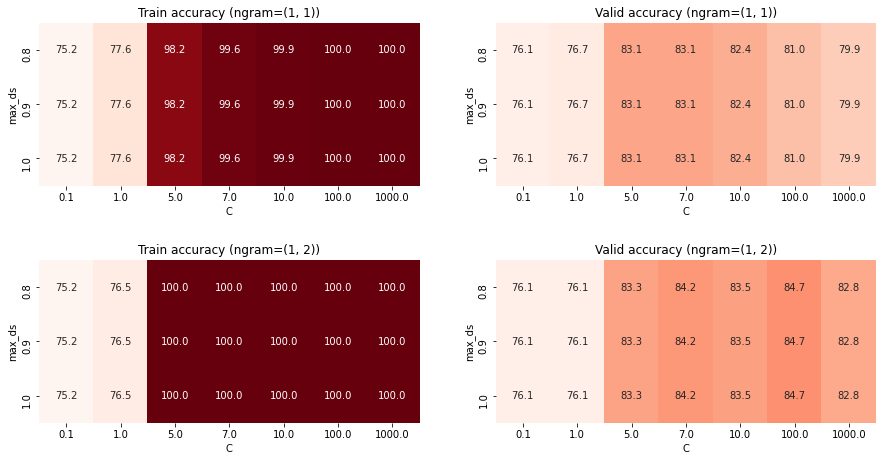

In [40]:
# Trực quan hóa kết quả
train_acc_11_df = pd.DataFrame(data=np.array(en_train_accs[:21]).reshape(len(max_ds), -1),
                             index=max_ds, columns=C_param)
train_acc_12_df = pd.DataFrame(data=np.array(en_train_accs[21:]).reshape(len(max_ds), -1), 
                           index=max_ds, columns=C_param)
valid_acc_11_df = pd.DataFrame(data=np.array(en_valid_accs[:21]).reshape(len(max_ds), -1),
                             index=max_ds, columns=C_param)
valid_acc_12_df = pd.DataFrame(data=np.array(en_valid_accs[21:]).reshape(len(max_ds), -1), 
                           index=max_ds, columns=C_param)
min_acc = min(min(en_train_accs), min(en_valid_accs))
max_acc = max(max(en_train_accs), max(en_valid_accs))
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.heatmap(train_acc_11_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Train accuracy (ngram=(1, 1))'); plt.xlabel('C'); plt.ylabel('max_ds')
plt.subplot(2, 2, 2)
sns.heatmap(valid_acc_11_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Valid accuracy (ngram=(1, 1))'); plt.xlabel('C'); plt.ylabel('max_ds')

plt.subplot(2, 2, 3)
sns.heatmap(train_acc_12_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Train accuracy (ngram=(1, 2))'); plt.xlabel('C'); plt.ylabel('max_ds')
plt.subplot(2, 2, 4)
sns.heatmap(valid_acc_12_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Valid accuracy (ngram=(1, 2))'); plt.xlabel('C'); plt.ylabel('max_ds')

#### Tìm mô hình tốt nhất cho tiếng Việt

In [41]:
vi_best_val_acc = 0
vi_best_C = None; 
vi_best_ngram = None
vi_best_maxdf = None
vi_train_accs = []
vi_valid_accs = []

# brute-force search
for ngram_range in ngram_ranges:
    for max_d in max_ds:
        for C in C_param:
            vi_clf_pipeline.set_params(vectorize__ngram_range=ngram_range, vectorize__max_df=max_d, clf__C=C)
            vi_clf_pipeline.fit(transformed_vi_train_X, vi_train_y)
            
            # Tính độ chính xác trên tập train
            train_pred = vi_clf_pipeline.predict(transformed_vi_train_X)
            train_acc = np.mean(train_pred == vi_train_y) * 100
            vi_train_accs.append(train_acc)
            
            # Tính độ chính xác trên tập valid
            val_pred = vi_clf_pipeline.predict(transformed_vi_valid_X)
            valid_acc = np.mean(val_pred == vi_valid_y) * 100
            vi_valid_accs.append(valid_acc)
            
            # Tìm siêu tham số tốt nhất
            if vi_best_val_acc < valid_acc:
                vi_best_val_acc = valid_acc
                vi_best_C = C
                vi_best_ngram = ngram_range
                vi_best_maxdf = max_d

In [42]:
vi_best_C, vi_best_ngram, vi_best_maxdf

(100, (1, 2), 0.8)

Text(570.5454545454544, 0.5, 'max_ds')

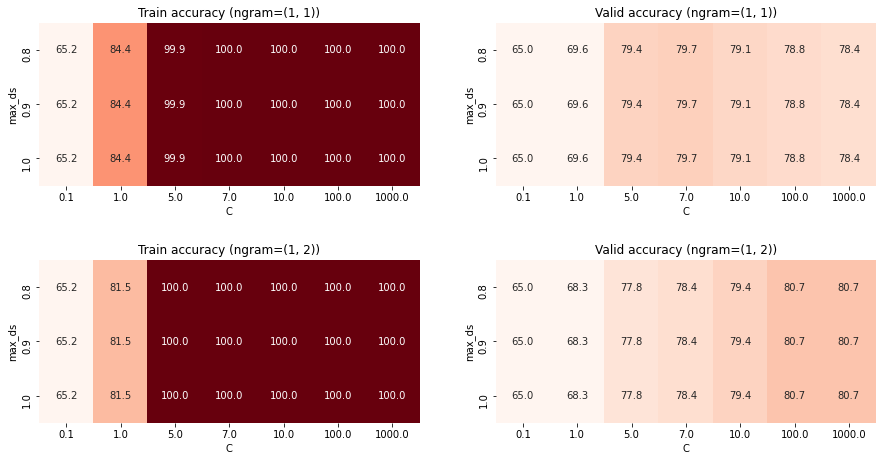

In [43]:
# Trực quan hóa kết quả
train_acc_11_df = pd.DataFrame(data=np.array(vi_train_accs[:21]).reshape(len(max_ds), -1),
                             index=max_ds, columns=C_param)
train_acc_12_df = pd.DataFrame(data=np.array(vi_train_accs[21:]).reshape(len(max_ds), -1), 
                           index=max_ds, columns=C_param)
valid_acc_11_df = pd.DataFrame(data=np.array(vi_valid_accs[:21]).reshape(len(max_ds), -1),
                             index=max_ds, columns=C_param)
valid_acc_12_df = pd.DataFrame(data=np.array(vi_valid_accs[21:]).reshape(len(max_ds), -1), 
                           index=max_ds, columns=C_param)
min_acc = min(min(en_train_accs), min(en_valid_accs))
max_acc = max(max(en_train_accs), max(en_valid_accs))
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.heatmap(train_acc_11_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Train accuracy (ngram=(1, 1))'); plt.xlabel('C'); plt.ylabel('max_ds')
plt.subplot(2, 2, 2)
sns.heatmap(valid_acc_11_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Valid accuracy (ngram=(1, 1))'); plt.xlabel('C'); plt.ylabel('max_ds')

plt.subplot(2, 2, 3)
sns.heatmap(train_acc_12_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Train accuracy (ngram=(1, 2))'); plt.xlabel('C'); plt.ylabel('max_ds')
plt.subplot(2, 2, 4)
sns.heatmap(valid_acc_12_df, vmin=min_acc, vmax=max_acc, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('Valid accuracy (ngram=(1, 2))'); plt.xlabel('C'); plt.ylabel('max_ds')

### Đánh giá mô hình

Đánh giá mô hình trên tập test.

#### Hiệu suất mô hình tiếng Anh

In [44]:
# Huấn luyện lại toàn bộ mô hình trên siêu tham số mới
en_full_pipeline.set_params(vectorize__ngram_range=en_best_ngram, vectorize__max_df=en_best_maxdf, clf__C=en_best_C)
en_full_pipeline.fit(en_train_X.overview, en_train_y)

test_pred = en_full_pipeline.predict(en_test_X.overview)
test_acc = np.mean(test_pred == en_test_y)*100
print("Test Accuracy: %.2f" % test_acc)

Test Accuracy: 81.76


#### Hiệu suất mô hình tiếng Việt

In [45]:
# Huấn luyện lại toàn bộ mô hình trên siêu tham số mới
vi_full_pipeline.set_params(vectorize__ngram_range=vi_best_ngram, vectorize__max_df=vi_best_maxdf, clf__C=vi_best_C)
vi_full_pipeline.fit(vi_train_X.overview, vi_train_y)

test_pred = vi_full_pipeline.predict(vi_test_X.overview)
test_acc = np.mean(test_pred == vi_test_y)*100
print("Test Accuracy: %.2f" % test_acc)

Test Accuracy: 69.09


### Mô hình xử lí ảnh

Vì ảnh đã được chuyển sang dạng histogram nên không có quá nhiều kĩ thuật tiền xử lí.

#### Tiền xử lí

In [46]:
class ImageParser(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        transformed_X = X.apply(lambda pixel: [float(p) for p in pixel.split()])
        transformed_X = np.array(transformed_X.values.tolist())
        
        return transformed_X

In [47]:
img_parser = ImageParser()

# Train
X_img_train = img_parser.transform(train_data.imagePixels)
y_img_train = train_data.is_adult

# Valid
X_img_valid = img_parser.transform(valid_data.imagePixels)
y_img_valid = valid_data.is_adult


#### Mô hình hóa

Nhóm sẽ xây dựng mô hình phân loại ảnh đơn giản bằng Logistic Regression để hỗ trợ cho mô hình phân loại ảnh

In [48]:
img_pipeline = Pipeline([
    ('parser', ImageParser()),
    ('clf', LogisticRegression(C=1.0, solver='lbfgs', random_state=42, max_iter=1000))
])

clf = LogisticRegression(C=C, solver='lbfgs', random_state=42, max_iter=1000)
clf.fit(X_img_train, y_img_train)

# đánh giá tập train
y_pred = clf.predict(X_img_train)
train_acc = np.mean(y_pred == y_img_train)*100
print("Độ chính xác tập train: %.2f" % train_acc)

# đánh giá tập valid
y_pred = clf.predict(X_img_valid)
valid_acc = np.mean(y_pred == y_img_valid)*100
print("Độ chính xác tập valid: %.2f" % valid_acc)


Độ chính xác tập train: 73.61
Độ chính xác tập valid: 70.76


#### Hyperparameter tuning

Điều chỉnh siêu tham số C của mô hình.

In [49]:
best_val_acc = 0
best_C = None; 
train_accs = []
valid_accs = []
# Tìm mô hình phân loại ảnh tốt nhất
for C in [0.01, 0.1, 10, 50, 100, 1000]:
    clf = LogisticRegression(C=C, solver='lbfgs', random_state=42, max_iter=1000)
    clf.fit(X_img_train, y_img_train)
    
    # đánh giá tập train
    y_pred = clf.predict(X_img_train)
    train_acc = np.mean(y_pred == y_img_train)*100
    train_accs.append(train_acc)

    # đánh giá tập valid
    y_pred = clf.predict(X_img_valid)
    valid_acc = np.mean(y_pred == y_img_valid)*100
    valid_accs.append(valid_acc)
    
    # Tìm ra hyperparameter tốt nhất
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        best_C = C

print("Siêu tham số C tốt nhất:", best_C)
print("Độ chính xác tập valid tốt nhất:", best_val_acc)
print("Train accs:", train_accs)
print("Valid accs:", valid_accs)

Siêu tham số C tốt nhất: 50
Độ chính xác tập valid tốt nhất: 71.69559412550068
Train accs: [72.23786066150598, 72.23786066150598, 72.34342012667135, 72.5545390570021, 72.97677691766363, 73.61013370865588]
Valid accs: [71.56208277703605, 71.56208277703605, 71.56208277703605, 71.69559412550068, 71.42857142857143, 70.76101468624833]


#### Đánh giá hiệu quả mô hình trên tập test

In [50]:
# Đặt siêu tham số tốt nhất
img_pipeline.set_params(clf__C=best_C)

# Huấn luyện toàn bộ lại
img_pipeline.fit(train_data.imagePixels, train_data.is_adult)

# đánh giá trên tập test
y_pred = img_pipeline.predict(test_data.imagePixels)
test_acc = np.mean(y_pred == test_data.is_adult)*100

print("Test Accuracy: %.2f" % test_acc)

Test Accuracy: 74.55


### Kết hợp kết quả của hai mô hình ngôn ngữ và ảnh

Sau khi đã huấn luyện được 2 loại mô hình là mô hình ngôn ngữ và mô hình xử lí ảnh. Để kết hợp được sức mạnh của hai mô hình, thư viện `scikit-learn` có hàm hỗ trợ dự đoán xác suất là `predict_proba`. Việc kết hợp sẽ thực hiện bằng cách tính _trung bình_ giữa 2 kết quả của 2 loại mô hình trên để phân loại.

#### Kết hợp trên tập tiếng Anh

In [51]:
en_test_pred = en_full_pipeline.predict_proba(en_test_X.overview)
img_test_pred = img_pipeline.predict_proba(en_test_X.imagePixels)

test_pred = np.argmax((en_test_pred + img_test_pred) / 2, axis=1)

test_acc = np.mean(test_pred == en_test_y)*100

print("Test Accuracy: %.2f" % test_acc)

Test Accuracy: 81.53


#### Kết hợp trên tập tiếng Việt

In [52]:
vi_test_pred = vi_full_pipeline.predict_proba(vi_test_X.overview)
img_test_pred = img_pipeline.predict_proba(vi_test_X.imagePixels)

test_pred = np.argmax((vi_test_pred + img_test_pred) / 2, axis=1)

test_acc = np.mean(test_pred == vi_test_y)*100

print("Test Accuracy: %.2f" % test_acc)

Test Accuracy: 78.18


* **Kết luận**: Sau khi kết hợp 2 mô hình ngôn ngữ và ảnh thì kết quả trên tập test được cải thiện khá nhiều. Trên tập tiếng Việt (\~9.1%), riêng trên tập tiếng Anh thì hiệu suất bị giảm đi một ít, không đáng kể (\~0.23%). Để tránh việc giảm này có thể thử nghiệm cách đặt trọng số weight cho giá trị dự đoán của mỗi mô hình để giảm đi sự ảnh hưởng của 1 trong 2 mô hình phân loại trên.

---

## Nhìn lại quá trình làm đồ án

### Những khó khăn

- Giới hạn độ tuổi mà trang phim cung cấp không thống nhất, nhiều metadata khác nhau cho nên dữ liệu thu thập chứa đa dạng lớp. Để giải quyết vấn đề này, gộp các lớp lại còn 2 cụm chưa đủ 18 và đủ 18 thì phải thực hiện một cách thủ công.

### Bài học rút ra

- Cách triển khai một mô hình xử lí ngôn ngữ đơn giản sử dụng Bag of word
- Đặc điểm khác nhau giữa xử lí ngôn ngữ tiếng Anh và tiếng Việt

Nếu có thêm thời gian, nhóm sẽ tận dụng những thêm những đặc trưng khác để mô hình có thể xử lí được nhiều trường hợp phức tạp hơn. Đồng thời sẽ tìm hiểu thêm những mô hình nổi bật trong xử lí ngôn ngữ tự nhiên như Word2vec, BERT,... để mô hình nâng cao hơn, có thể hiểu được ngữ nghĩa và thứ tự của các từ. Cũng như tìm hiểu về các mô hình xử lí ảnh như ResNet, EfficientNet,... Ngoài ra, có thể thử nghiệm thay vì lấy trung bình kết quả dự đoán của hai mô hình ngôn ngữ và ảnh thì có thể kết hợp đặc trưng của hai mô hình lại rồi cho qua 1 mô hình phân loại.

## Tài liệu tham khảo

1. [scikit-learn User Guide](https://scikit-learn.org/)
2. [Stackoverflow](https://stackoverflow.com/)
3. [Pandas Documentation](https://pandas.pydata.org/)
4. [Stemming and Lemmatization in Python](https://www.datacamp.com/community/tutorials/stemming-lemmatization-python)
5. [Vietnamese stopwords](https://github.com/stopwords/vietnamese-stopwords)
6. [Joblib](https://joblib.readthedocs.io/en/latest/)